In [1]:
import iris
from scipy.spatial import KDTree
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import iris.coord_categorisation
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import pandas as pd
import datetime
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
import matplotlib

In [2]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)

def extract_lat_lon(cube,my_lat,my_lon):
    lat = cube.coord('latitude')
    lon = cube.coord('longitude')
    lat_coord1 = lat.nearest_neighbour_index(my_lat)
    lon_coord1 = lon.nearest_neighbour_index(my_lon)
    return cube.data[:,lat_coord1,lon_coord1].data


def extract_lat_lon_cube(cube,my_lat,my_lon):
    lat = cube.coord('latitude')
    lon = cube.coord('longitude')
    lat_coord1 = lat.nearest_neighbour_index(my_lat)
    lon_coord1 = lon.nearest_neighbour_index(my_lon)
    return cube[:,lat_coord1,lon_coord1]

In [3]:
file = '/Users/ph290/Downloads/era5_GBR/era5_GBR_surfacetemperature.nc'
file_bottom = '/Users/ph290/Downloads/era5_GBR/era5_GBR_bottomtemperature.nc'

# cube = iris.load_cube(file)[0]

cube_all_bottom = iris.load_cube(file_bottom)
cube_all = iris.load_cube(file)
try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
    iris.coord_categorisation.add_month(cube_all, 'time', name='month')
except:
    pass

try:
    iris.coord_categorisation.add_year(cube_all_bottom, 'time', name='year')
    iris.coord_categorisation.add_month(cube_all_bottom, 'time', name='month')
except:
    pass

# cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)


# cube_all.coord('longitude').points = cube_all.coord('longitude').points+180
# cube_all.data = np.ma.masked_array(cube_all.data)
# cube_all.data.fill_value = 9.96920997e+36
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
cube_all_bottom.data = np.ma.masked_where(cube_all_bottom.data == 9.96920997e+36, cube_all_bottom.data)

a = cube_all[0,:,:].data.copy()
a = np.ma.masked_where(np.logical_not(np.isfinite(a)),a)
x,y=np.meshgrid(cube_all.coord('longitude').points,cube_all.coord('latitude').points)
xygood = np.array((x[~a.mask],y[~a.mask])).T


In [4]:
#https://portal.aodn.org.au/search

# obs_file = 'NRSNSI.csv.gz'
# obs_file = 'GBRLSH.csv.gz'
# obs_file = 'GBRPPS.csv.gz'
# obs_file = 'NRSYON.csv.gz'
# obs_file = 'GBRHIS.csv.gz'
# df = pd.read_csv('data/'+obs_file, compression='gzip',header=21)


obs_file = 'IMOS_FAIMMS.csv.gz'
df = pd.read_csv('data/'+obs_file, compression='gzip',header=39)



In [5]:
df2 = df.loc[df.NOMINAL_DEPTH < 2.0]

site_codes = np.unique(df2.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
# site_code = site_codes[24]
site_code = site_codes[14]
df_surf = df2.loc[(df2.site_code == site_code) & (df.VALUES_quality_control == 1)]
lat = df_surf.LATITUDE.mean()
lon = df_surf.LONGITUDE.mean()

In [6]:
site_codes

array(['HIRP1', 'HIRP2', 'HIRP5', 'HIRP6', 'HIRP8', 'HISF1', 'HISF2',
       'HISF3', 'HISF4', 'LIZSF2', 'LIZSF3', 'OIRP2', 'OTIRP1', 'OTIRP2',
       'OTIRP3'], dtype=object)

In [7]:


min_lon = np.min(cube_all.coord('longitude').points)
max_lon = np.max(cube_all.coord('longitude').points)
min_lat = np.min(cube_all.coord('latitude').points)
max_lat = np.max(cube_all.coord('latitude').points)

# if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
#     fig= plt.subplots(figsize=(10, 10))
#     #plot map of the mooring location
#     qplt.pcolormesh(cube_all[0])
#     plt.scatter(lon,lat)
#     plt.show()



In [8]:
obs_values=np.array([])
obs_latitude=np.array([])
obs_month=np.array([])
model_values=np.array([])


site_codes = np.unique(df2.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
for site_code in site_codes:
    print(site_code)
    df_surf = df2.loc[(df.site_code == site_code) & (df2.VALUES_quality_control == 1)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()

#     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            try:
        #         df_surf['old_TIME'] = df_surf.TIME
                df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
                df_surf = df_surf.set_index('TIME_datetime',drop=False)
            except:
                pass
            df_surf['month'] = df_surf.TIME_datetime.dt.month
            df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()

            basedate = pd.Timestamp('1970-01-01')

            model_dates = times[where_good_data].astype('datetime64[ns]')
            model_days_since_bas = (pd.to_datetime(model_dates) - basedate).days.values
            model_data = model_ts[where_good_data]
            
            obs_days_since_bas = (df_surf.index- basedate).days.values
#             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))
#             obs_days_since_bas = obs_days_since_bas[finite_obs_data_loc]
            loc_where_obs_days_within_model_days =  np.where((obs_days_since_bas <= np.max(model_days_since_bas)) & (np.isfinite(df_surf.VALUES.values)) & (df_surf.VALUES.values >17.0 ))[0]
            obs_days_since_bas = obs_days_since_bas[loc_where_obs_days_within_model_days]
#             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))

            interp_function = interp1d(model_days_since_bas, model_data)

            # plt.scatter(obs_days_since_bas,df_surf.VALUES.values[finite_obs_data_loc],color='r',alpha=0.5)
#             plt.scatter(obs_days_since_bas, interp_function(obs_days_since_bas), color='b',alpha=0.1)
            obs_values = np.append(obs_values, df_surf.VALUES.values[loc_where_obs_days_within_model_days])
            model_values = np.append(model_values, interp_function(obs_days_since_bas))
            obs_latitude = np.append(obs_latitude,df_surf.LATITUDE.values[loc_where_obs_days_within_model_days])
            obs_month = np.append(obs_month,df_surf.month.values[loc_where_obs_days_within_model_days])
#             plt.scatter(df_surf.VALUES.values[loc_where_obs_days_within_model_days],interp_function(obs_days_since_bas))

    #     if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
    #         plt.plot(times[where_good_data],model_ts[where_good_data])
    #         try:
    #     #         df_surf['old_TIME'] = df_surf.TIME
    #             df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
    #             df_surf['year'] = df_surf.TIME_datetime.dt.year
    #             df_surf['month'] = df_surf.TIME_datetime.dt.month
    #             df_surf['day'] = df_surf.TIME_datetime.dt.day
    #             df_surf = df_surf.set_index('TIME_datetime',drop=False)
    #         except:
    #             pass

    #         df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()
    #         plt.scatter(df_surf.index.values,df_surf.VALUES.values,color='r')
    #         plt.show()



HIRP1


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HIRP2


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HIRP5


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HIRP6


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HIRP8


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HISF1


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HISF2


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HISF3


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


HISF4


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


LIZSF2


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


LIZSF3


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


OIRP2


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


OTIRP1


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


OTIRP2


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


OTIRP3


<ipython-input-8-c836f6849eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')


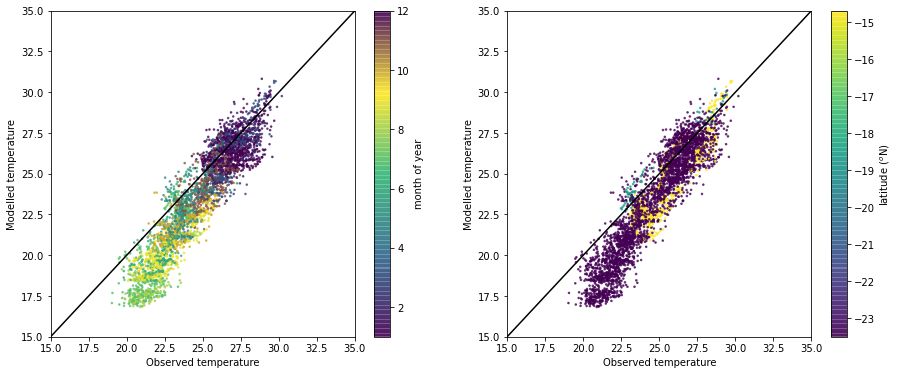

In [9]:
import matplotlib.cm
import matplotlib.colors

cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

x,y=obs_values,model_values
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month, s=2.5,alpha=0.7, cmap=cyclic_viridis)
ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed temperature')
ax1.set_ylabel('Modelled temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude, s=2.5,alpha=0.7, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed temperature')
ax2.set_ylabel('Modelled temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validation_IMOS_FAIMMS.pdf')
# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_FAIMMS.png')

plt.show()

# Bottom temperatures

In [10]:

# obs_file = 'NRSNSI.csv.gz' # 63m
# obs_file = 'GBRLSH.csv.gz' # 31m
# obs_file = 'GBRPPS.csv.gz' # 68m
# obs_file = 'NRSYON.csv.gz' # 27m
# obs_file = 'GBRHIS.csv.gz' # 43m
# obs_file = 'GBROTE.csv.gz' #59.3m
# df_bottom = pd.read_csv('data/'+obs_file, compression='gzip',header=21)


In [11]:
sites = ['NRSNSI','GBRLSH','NRSYON','GBRHIS']
depths =[63,31,27,43]

In [12]:


obs_values_bottom=np.array([])
obs_latitude_bottom=np.array([])
obs_month_bottom=np.array([])
model_values_bottom=np.array([])

for i,dummy in enumerate(sites):
    df_bottom = pd.read_csv('data/'+sites[i]+'.csv.gz', compression='gzip',header=21)

    df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-5.0]
#     df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-2.0]

    try:
        lat = df_bottom_tmp.LATITUDE.mean()
    except:
        lat = df_bottom_tmp.LATITUDE.iloc[0]

    try:
        lon = df_bottom_tmp.LONGITUDE.mean()
    except:
        lon = df_bottom_tmp.LONGITUDE.iloc[0]
        
    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all_bottom,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            try:
        #         df_surf['old_TIME'] = df_surf.TIME
                df_bottom_tmp['TIME_datetime'] = pd.to_datetime(df_bottom_tmp.TIME,format='%Y-%m-%dT%H:%M:%SZ')
                df_bottom_tmp = df_bottom_tmp.set_index('TIME_datetime',drop=False)
            except:
                pass
            df_bottom_tmp['month'] = df_bottom_tmp.TIME_datetime.dt.month
            df_bottom_tmp = df_bottom_tmp.groupby(pd.Grouper(freq='1D')).mean()

            basedate = pd.Timestamp('1970-01-01')

            model_dates = times[where_good_data].astype('datetime64[ns]')
            model_days_since_bas = ( pd.to_datetime(model_dates)- basedate).days.values
            model_data = model_ts[where_good_data]

            obs_days_since_bas = (df_bottom_tmp.index- basedate).days.values
    #             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))
    #             obs_days_since_bas = obs_days_since_bas[finite_obs_data_loc]
            loc_where_obs_days_within_model_days =  np.where((obs_days_since_bas <= np.max(model_days_since_bas)) & (np.isfinite(df_bottom_tmp.TEMP.values)))[0]
            obs_days_since_bas = obs_days_since_bas[loc_where_obs_days_within_model_days]
    #             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))

            interp_function = interp1d(model_days_since_bas, model_data)

            # plt.scatter(obs_days_since_bas,df_surf.VALUES.values[finite_obs_data_loc],color='r',alpha=0.5)
    #             plt.scatter(obs_days_since_bas, interp_function(obs_days_since_bas), color='b',alpha=0.1)
            obs_values_bottom = np.append(obs_values_bottom, df_bottom_tmp.TEMP.values[loc_where_obs_days_within_model_days])
            model_values_bottom = np.append(model_values_bottom, interp_function(obs_days_since_bas))
            obs_latitude_bottom = np.append(obs_latitude_bottom,df_bottom_tmp.LATITUDE.values[loc_where_obs_days_within_model_days])
            obs_month_bottom = np.append(obs_month_bottom,df_bottom_tmp.month.values[loc_where_obs_days_within_model_days])

<ipython-input-12-8e4d6ec7d235>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bottom_tmp['TIME_datetime'] = pd.to_datetime(df_bottom_tmp.TIME,format='%Y-%m-%dT%H:%M:%SZ')
<ipython-input-12-8e4d6ec7d235>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bottom_tmp['TIME_datetime'] = pd.to_datetime(df_bottom_tmp.TIME,format='%Y-%m-%dT%H:%M:%SZ')
<ipython-input-12-8e4d6ec7d235>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

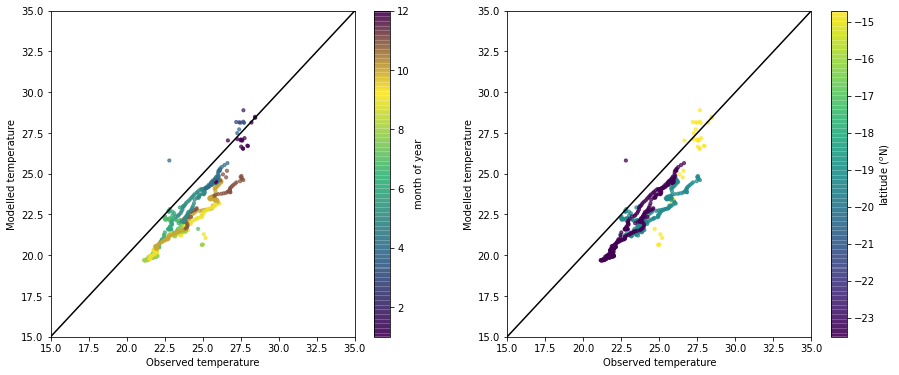

In [13]:
import matplotlib.cm
import matplotlib.colors

cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

x,y=obs_values_bottom,model_values_bottom
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude_bottom, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month_bottom, s=10,alpha=0.7, cmap=cyclic_viridis)
ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed temperature')
ax1.set_ylabel('Modelled temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude_bottom, s=10,alpha=0.7, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed temperature')
ax2.set_ylabel('Modelled temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_bottom_t_validation_IMOS_FAIMMS.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_bottom_t_validationIMOS_FAIMMS.png')

plt.show()

### Surface and bottom together

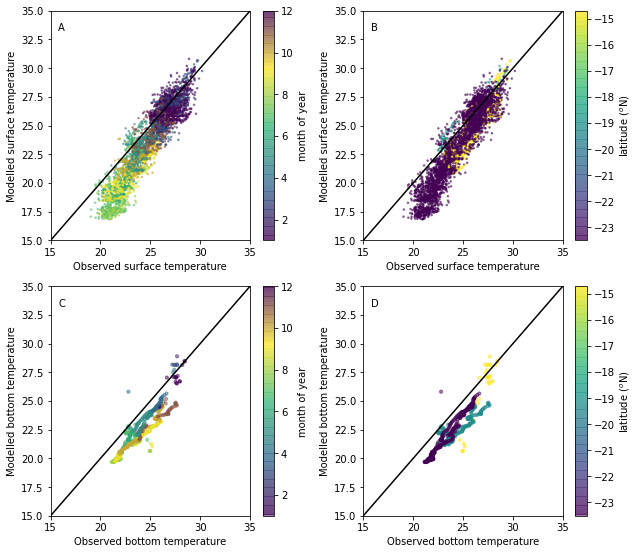

In [14]:
import matplotlib.cm
import matplotlib.colors

def get_axis_limits(ax, xscale=.45, yscale=.95):
    return ax.get_xlim()[1]*xscale, ax.get_ylim()[1]*yscale


cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

### surface

x,y=obs_values,model_values
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15*0.6,13*0.6))
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,13))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month, s=2.5,alpha=0.5, cmap=cyclic_viridis)
ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed surface temperature')
ax1.set_ylabel('Modelled surface temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude, s=2.5,alpha=0.5, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed surface temperature')
ax2.set_ylabel('Modelled surface temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


### bottom

x,y=obs_values_bottom,model_values_bottom
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude_bottom, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax3.scatter(x, y, c=obs_month_bottom, s=10,alpha=0.5, cmap=cyclic_viridis)
ax3.set_ylim([15,35])
ax3.set_xlim([15,35])
ax3.set_xlabel('Observed bottom temperature')
ax3.set_ylabel('Modelled bottom temperature')
ax3.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax3)
cbar1.set_label('month of year')


c2 = ax4.scatter(x, y, c=obs_latitude_bottom, s=10,alpha=0.5, cmap=cm.viridis)
ax4.set_ylim([15,35])
ax4.set_xlim([15,35])
ax4.set_xlabel('Observed bottom temperature')
ax4.set_ylabel('Modelled bottom temperature')
ax4.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax4)
cbar2.set_label('latitude ($^o$N)')

ax1.annotate('A', xy=get_axis_limits(ax1))
ax2.annotate('B', xy=get_axis_limits(ax2))
ax3.annotate('C', xy=get_axis_limits(ax3))
ax4.annotate('D', xy=get_axis_limits(ax4))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

plt.tight_layout()

# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validation_IMOS_surf_and_bottom.pdf')
# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_surf_and_bottom.png')

plt.show()

In [ ]:
import matplotlib.cm
import matplotlib.colors

def get_axis_limits(ax, xscale=.45, yscale=.95):
    return ax.get_xlim()[1]*xscale, ax.get_ylim()[1]*yscale


cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

### surface

x,y=obs_values,model_values
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(4, 3, wspace=0.3,hspace=0.3)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax3 = fig.add_subplot(gs[0:2, 1])
ax4 = fig.add_subplot(gs[2:4, 1])

# # fig, ((ax1, ax2,ax5a), (ax3, ax4,ax5b)) = plt.subplots(2,3,figsize=(15*0.6,13*0.6))
# # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,13))
# # ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# # c = ax.scatter(x, y, c=obs_latitude, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month, s=2.5,alpha=0.5, cmap=cyclic_viridis)

ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed surface temperature')
ax1.set_ylabel('Modelled surface temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude, s=2.5,alpha=0.5, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed surface temperature')
ax2.set_ylabel('Modelled surface temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


## bottom

x,y=obs_values_bottom,model_values_bottom
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude_bottom, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax3.scatter(x, y, c=obs_month_bottom, s=10,alpha=0.5, cmap=cyclic_viridis)
ax3.set_ylim([15,35])
ax3.set_xlim([15,35])
ax3.set_xlabel('Observed bottom temperature')
ax3.set_ylabel('Modelled bottom temperature')
ax3.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax3)
cbar1.set_label('month of year')


c2 = ax4.scatter(x, y, c=obs_latitude_bottom, s=10,alpha=0.5, cmap=cm.viridis)
ax4.set_ylim([15,35])
ax4.set_xlim([15,35])
ax4.set_xlabel('Observed bottom temperature')
ax4.set_ylabel('Modelled bottom temperature')
ax4.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax4)
cbar2.set_label('latitude ($^o$N)')

ax1.annotate('A', xy=get_axis_limits(ax1))
ax2.annotate('B', xy=get_axis_limits(ax2))
ax3.annotate('C', xy=get_axis_limits(ax3))
ax4.annotate('D', xy=get_axis_limits(ax4))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# -------

# fig = plt.figure(figsize=(8,8))

projection=ccrs.PlateCarree()
# ax3 = plt.axes([0, 0, 1, 1], projection=projection)
# fig = plt.figure(figsize=(5, 6))
# ax5 = fig.add_subplot(1, 3, 3, projection=projection)
ax5 = fig.add_subplot(gs[1:3, 2], projection=projection)
ax5.set_extent([135, 160, -40, -5], ccrs.PlateCarree())
ax5.coastlines('50m')


for i,dummy in enumerate(sites):
    df_bottom = pd.read_csv('data/'+sites[i]+'.csv.gz', compression='gzip',header=21)
    df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-5.0]

    try:
        lat = df_bottom_tmp.LATITUDE.mean()
    except:
        lat = df_bottom_tmp.LATITUDE.iloc[0]

    try:
        lon = df_bottom_tmp.LONGITUDE.mean()
    except:
        lon = df_bottom_tmp.LONGITUDE.iloc[0]
        
    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all_bottom,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            if i== 0:
                ax5.scatter(lon,lat,color='b',s=200,alpha=0.3,label='bottom observations')
            else:
                ax5.scatter(lon,lat,color='b',s=200,alpha=0.3)


site_codes = np.unique(df.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
add_label=True
for i,site_code in enumerate(site_codes):
    df_surf = df.loc[(df.site_code == site_code) & (df.VALUES_quality_control == 1)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()
    if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
        if add_label:
            ax5.scatter(lon,lat,color='r',s=50,alpha=0.5,label='surface observations')
            add_label = False
        else:
            ax5.scatter(lon,lat,color='r',s=50,alpha=0.5)


ax5.set_title('E')

plt.legend()

# ax5.annotate('E', xy=get_axis_limits(ax5))

# -------


# plt.tight_layout()

# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validation_IMOS_surf_and_bottom.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_surf_and_bottom2.png')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15*0.6,13*0.6))
gs = fig.add_gridspec(4, 3)

projection=ccrs.PlateCarree()
# ax3 = plt.axes([0, 0, 1, 1], projection=projection)
# fig = plt.figure(figsize=(5, 6))
# ax5 = fig.add_subplot(1, 3, 3, projection=projection)
ax5 = fig.add_subplot(gs[1:3, 2], projection=projection)
ax5.set_extent([135, 160, -40, -5], ccrs.PlateCarree())
ax5.coastlines('50m')


for i,dummy in enumerate(sites):
    df_bottom = pd.read_csv('data/'+sites[i]+'.csv.gz', compression='gzip',header=21)
    df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-5.0]

    try:
        lat = df_bottom_tmp.LATITUDE.mean()
    except:
        lat = df_bottom_tmp.LATITUDE.iloc[0]

    try:
        lon = df_bottom_tmp.LONGITUDE.mean()
    except:
        lon = df_bottom_tmp.LONGITUDE.iloc[0]
        
    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all_bottom,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            if i== 0:
                ax5.scatter(lon,lat,color='b',s=200,alpha=0.3,label='bottom observations')
            else:
                ax5.scatter(lon,lat,color='b',s=200,alpha=0.3)


site_codes = np.unique(df.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
add_label=True
for i,site_code in enumerate(site_codes):
    df_surf = df.loc[(df.site_code == site_code) & (df.VALUES_quality_control == 1)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()
    if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
        if add_label:
            ax5.scatter(lon,lat,color='r',s=50,alpha=0.5,label='surface observations')
            add_label = False
        else:
            ax5.scatter(lon,lat,color='r',s=50,alpha=0.5)

plt.legend()


# -------


# plt.tight_layout()

# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validation_IMOS_surf_and_bottom.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_surf_and_bottom2.png')

plt.show()

In [ ]:
# fig = plt.figure(figsize=(8,8))

projection=ccrs.PlateCarree()
# ax3 = plt.axes([0, 0, 1, 1], projection=projection)
fig = plt.figure(figsize=(5, 6))
ax3 = fig.add_subplot(1, 1, 1, projection=projection)
ax3.set_extent([135, 160, -40, -5], ccrs.PlateCarree())
ax3.coastlines('50m')


for i,dummy in enumerate(sites):
    df_bottom = pd.read_csv('data/'+sites[i]+'.csv.gz', compression='gzip',header=21)
    df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-5.0]

    try:
        lat = df_bottom_tmp.LATITUDE.mean()
    except:
        lat = df_bottom_tmp.LATITUDE.iloc[0]

    try:
        lon = df_bottom_tmp.LONGITUDE.mean()
    except:
        lon = df_bottom_tmp.LONGITUDE.iloc[0]
        
    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all_bottom,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            if i== 0:
                ax3.scatter(lon,lat,color='b',s=200,alpha=0.3,label='bottom observations')
            else:
                ax3.scatter(lon,lat,color='b',s=200,alpha=0.3)


site_codes = np.unique(df.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
add_label=True
for i,site_code in enumerate(site_codes):
    df_surf = df.loc[(df.site_code == site_code) & (df.VALUES_quality_control == 1)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()
    if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
        if add_label:
            ax3.scatter(lon,lat,color='r',s=50,alpha=0.5,label='surface observations')
            add_label = False
        else:
            ax3.scatter(lon,lat,color='r',s=50,alpha=0.5)

plt.legend()
fig.tight_layout(pad=3)
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_bottom_sites.png',dpi=600)


# biology

In [ ]:
#https://portal.aodn.org.au/search

obs_file = 'IMOS_Australian_National_Mooring_Network_and_CTD_burst_averaged_data_products.csv.gz'
df4 = pd.read_csv('data/'+obs_file, compression='gzip',header=27)



In [ ]:
# list(df4)

In [ ]:
# df5 = df4.loc[df4.instrument_nominal_depth < 2.0]
df5 = df4.loc[df4.instrument_nominal_depth < 12.0] # neccesary to get a decent no. sites


In [ ]:

site_codes = np.unique(df5.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
# site_code = site_codes[24]

site_code = site_codes[0]
df_surf5 = df5.loc[(df5.site_code == site_code)]
lat = df_surf5.LATITUDE.mean()
lon = df_surf5.LONGITUDE.mean()

In [ ]:
# list(df5)

In [ ]:
file = '/Users/ph290/Downloads/era5_GBR/era5_GBR_surfacechlorophyll.nc'

cube_all_chl = iris.load_cube(file)
try:
    iris.coord_categorisation.add_year(cube_all_chl, 'time', name='year')
    iris.coord_categorisation.add_month(cube_all_chl, 'time', name='month')
except:
    pass

# cube_all_chl.data = np.ma.masked_where(cube_all_chl.data == 9.96920997e+36, cube_all.data)
cube_all_chl.data = np.ma.masked_where(cube_all_chl.data == 9.96920997e+36, cube_all_chl.data)

a = cube_all_chl[0,:,:].data.copy()
a = np.ma.masked_where(np.logical_not(np.isfinite(a)),a)
x,y=np.meshgrid(cube_all_chl.coord('longitude').points,cube_all_chl.coord('latitude').points)
xygood = np.array((x[~a.mask],y[~a.mask])).T

In [ ]:
min_lon = np.min(cube_all_chl.coord('longitude').points)
max_lon = np.max(cube_all_chl.coord('longitude').points)
min_lat = np.min(cube_all_chl.coord('latitude').points)
max_lat = np.max(cube_all_chl.coord('latitude').points)

In [ ]:
obs_values=np.array([])
obs_latitude=np.array([])
obs_month=np.array([])
model_values=np.array([])


site_codes = np.unique(df5.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
for site_code in site_codes:
# site_code = site_codes[0]
    df_surf = df5.loc[(df5.site_code == site_code)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()

    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts_cube = extract_lat_lon_cube(cube_all_chl,xygood[index][1],xygood[index][0])
        model_ts = model_ts_cube.data
        time = cube_all_chl.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            try:
        #         df_surf['old_TIME'] = df_surf.TIME
                df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
                df_surf = df_surf.set_index('TIME_datetime',drop=False)
            except:
                pass
            df_surf['month'] = df_surf.TIME_datetime.dt.month
            df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()

            basedate = pd.Timestamp('1970-01-01')

            model_dates = times[where_good_data].astype('datetime64[ns]')
            model_days_since_bas = ( pd.to_datetime(model_dates)- basedate).days.values
            model_data = model_ts[where_good_data].astype('datetime64[ns]')

            obs_days_since_bas = (df_surf.index- basedate).days.values
    #             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))
    #             obs_days_since_bas = obs_days_since_bas[finite_obs_data_loc]
            loc_where_obs_days_within_model_days =  np.where((obs_days_since_bas <= np.max(model_days_since_bas)) & (np.isfinite(df_surf.CPHL.values)))[0]
            obs_days_since_bas = obs_days_since_bas[loc_where_obs_days_within_model_days]
    #             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))

            interp_function = interp1d(model_days_since_bas, model_data)

            # plt.scatter(obs_days_since_bas,df_surf.VALUES.values[finite_obs_data_loc],color='r',alpha=0.5)
    #             plt.scatter(obs_days_since_bas, interp_function(obs_days_since_bas), color='b',alpha=0.1)
            obs_values = np.append(obs_values, df_surf.CPHL.values[loc_where_obs_days_within_model_days])
            model_values = np.append(model_values, interp_function(obs_days_since_bas))
            obs_latitude = np.append(obs_latitude,df_surf.LATITUDE.values[loc_where_obs_days_within_model_days])
            obs_month = np.append(obs_month,df_surf.month.values[loc_where_obs_days_within_model_days])
    #             plt.scatter(df_surf.VALUES.values[loc_where_obs_days_within_model_days],interp_function(obs_days_since_bas))

    #     if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
    #         plt.plot(times[where_good_data],model_ts[where_good_data])
    #         try:
    #     #         df_surf['old_TIME'] = df_surf.TIME
    #             df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
    #             df_surf['year'] = df_surf.TIME_datetime.dt.year
    #             df_surf['month'] = df_surf.TIME_datetime.dt.month
    #             df_surf['day'] = df_surf.TIME_datetime.dt.day
    #             df_surf = df_surf.set_index('TIME_datetime',drop=False)
    #         except:
    #             pass

    #         df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()
    #         plt.scatter(df_surf.index.values,df_surf.VALUES.values,color='r')
    #         plt.show()



In [ ]:
import matplotlib.cm
import matplotlib.colors

cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

x,y=obs_values,model_values
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month, s=10,alpha=0.7, cmap=cyclic_viridis)
# ax1.set_ylim([15,35])
# ax1.set_xlim([15,35])
ax1.set_xlabel('Observed chl')
ax1.set_ylabel('Modelled chl')
# ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude, s=10,alpha=0.7, cmap=cm.viridis)
# ax2.set_ylim([15,35])
# ax2.set_xlim([15,35])
ax2.set_xlabel('Observed chl')
ax2.set_ylabel('Modelled chl')
# ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_chl_validation_IMOS_FAIMMS.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_chl_validationIMOS_FAIMMS.png')

plt.show()

In [ ]:
df_surf.CPHL.values[loc_where_obs_days_within_model_days]

In [ ]:
interp_function(obs_days_since_bas)

In [ ]:
fig1 = plt.figure(figsize=(5,5))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)
ax = fig1.add_subplot(spec[0,0])

ax.plot(interp_function(obs_days_since_bas))
ax2 = ax.twinx()
ax2.plot(df_surf.CPHL.values[loc_where_obs_days_within_model_days],'r',alpha=0.5)
ax2.set_ylim([0.0,0.8])

In [ ]:
model_dates

In [ ]:
from string import ascii_uppercase
counter = 0


projection = ccrs.PlateCarree()

    
site_codes = np.unique(df5.site_code)


fig1 = plt.figure(figsize=(10,15))
spec = gridspec.GridSpec(ncols=2, nrows=len(site_codes), figure=fig1)

# 7,8,12,13,14,16,17,18,21,22,23,24
for i,site_code in enumerate(site_codes):
# site_code = site_codes[0]
    df_surf = df5.loc[(df5.site_code == site_code)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()
    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts_cube = extract_lat_lon_cube(cube_all_chl,xygood[index][1],xygood[index][0])
        model_ts = model_ts_cube.data
        time = cube_all_chl.coord('time')
        model_times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            ax = fig1.add_subplot(spec[i,0])
            df_surf['datetime'] = pd.to_datetime(df_surf['TIME'], format='%Y-%m-%dT%H:%M:%SZ')
            df_surf = df_surf.set_index('datetime')
#             df_surf = df_surf.between_time('18:00', '06:00') # Chlorophyll fluorescence in the daytime is quenched. When we derive chlorophyll from the data, we apply a flag to the derived daytime chlorophyll data. We do not currently apply a flag to daytime fluorescence data
            df_surf = df_surf.resample('M').mean()

            df_model = pd.DataFrame(model_ts,columns=['chl'])
            df_model.index = model_times.astype('datetime64[ns]')
            df_model['chl'][df_model['chl'] > 1.0e36] = np.nan
            df_model = df_model.resample('M').mean()
            ax2 = ax.twinx()
            y=np.log(df_model['chl'])
#             y=df_model['chl']
            ax2.plot(df_model.index,(y - np.median(y))/(np.std(y)),'r',label='S2P3R v2.0')
#             ax2.set_ylabel('normalised surface\nmodel chlorophyll').set_color('r')

            ax.set_ylim(-3,3)
            ax2.set_ylim(-3,3)
        
            loc = np.logical_not(np.isfinite(df_surf.CPHL.values))
            df_surf.CPHL.values[loc] = np.nan
#             df_surf.index.values[loc] = np.nan
            y = np.log(df_surf.CPHL.values)
            y = df_surf.CPHL.values
            ax.plot(df_surf.index.values,(y - np.nanmedian(y))/(np.nanstd(y)),color='k',label='observed')
            
#             ax.set_ylabel('normalised mooring chlorophyll\nwithin upper 10m').set_color('k')
            
            ax.set_xlim(datetime.datetime(2008, 1, 1, 0, 0),datetime.datetime(2020, 1, 1, 0, 0))

            
            # map

            ax3 = fig1.add_subplot(spec[i,1],projection=projection)

            ax3.set_extent([140, 155, -35, -10], ccrs.PlateCarree())

            
            ax3.add_feature(cfeature.LAND)
            ax3.coastlines('10m')

            lon_model = model_ts_cube.coord('longitude')
            lat_model = model_ts_cube.coord('latitude')
            ax3.scatter(lon, lat, color='b',marker='o',s=100, transform=projection,alpha=0.5)
            ax3.scatter(lon_model.points[0], lat_model.points[0], color='r',marker='o',s=100, transform=projection,alpha=0.5)

    #         ax.set_title(file.split('/')[-1].split('.')[0])
#             if i == len(site_codes)-1:
#                 ax.set_xlabel('year')

            def get_axis_limits(ax, scale=.9):
                x = ax.get_xlim()[1] - ax.get_xlim()[0]
                y = ax.get_ylim()[1] - ax.get_ylim()[0]
                return ax.get_xlim()[0] + x*(0.05), ax.get_ylim()[0] + y*0.80

            def get_axis_limits2(ax, scale=.9):
                x = ax.get_xlim()[1] - ax.get_xlim()[0]
                y = ax.get_ylim()[1] - ax.get_ylim()[0]
                return ax.get_xlim()[0] + x*(0.8), ax.get_ylim()[0] + y*0.80
            
            ax.annotate(ascii_uppercase[counter], xy=get_axis_limits(ax2))
            counter += 1
            ax3.annotate(ascii_uppercase[counter], xy=get_axis_limits2(ax3))
            counter += 1

ax = fig1.add_subplot(spec[:,0], frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
ax.set_xlabel("year")
ax.set_ylabel("normalised mooring log chlorophyll within upper 12m").set_color('k')
ax2 = ax.twinx()
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("normalised surface model log chlorophyll").set_color('r')

for item in [fig, ax, ax2]:
    item.patch.set_visible(False)

# plt.tight_layout()
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_chl_validationIMOS_FAIMMS_timeseries_log.png', transparent=True,dpi=600)


In [ ]:
df_surf = df5.loc[(df5.site_code == site_code)]
# note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
lat = df_surf.LATITUDE.mean()
lon = df_surf.LONGITUDE.mean()
if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
    index = KDTree(xygood).query([lon,lat])[1]
#     xygood[index][0]
    model_ts_cube = extract_lat_lon_cube(cube_all_chl,xygood[index][1],xygood[index][0])
    model_ts = model_ts_cube.data
    time = cube_all_chl.coord('time')
    model_times = time.units.num2date(time.points)
    where_good_data = np.where(model_ts < 1000.0)

fig1 = plt.figure(figsize=(10,15))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

ax = fig1.add_subplot(spec[0,0])
df_surf['datetime'] = pd.to_datetime(df_surf['TIME'], format='%Y-%m-%dT%H:%M:%SZ')
df_surf = df_surf.set_index('datetime')
#             df_surf = df_surf.between_time('18:00', '06:00') # Chlorophyll fluorescence in the daytime is quenched. When we derive chlorophyll from the data, we apply a flag to the derived daytime chlorophyll data. We do not currently apply a flag to daytime fluorescence data
df_surf = df_surf.resample('M').mean()

df_model = pd.DataFrame(model_ts,columns=['chl'])
df_model.index = model_times.astype('datetime64[ns]')
df_model['chl'][df_model['chl'] > 1.0e36] = np.nan
df_model = df_model.resample('M').mean()
ax2 = ax.twinx()
y=np.log(df_model['chl'])
# y=df_model['chl']
ax2.plot(df_model.index,(y - np.mean(y))/(np.std(y)),'r',label='S2P3R v2.0')
#             ax2.set_ylabel('normalised surface\nmodel chlorophyll').set_color('r')
ax.set_ylim(-2.0,2.0)
ax2.set_ylim(-2.0,2.0)

loc = np.logical_not(np.isfinite(df_surf.CPHL.values))
df_surf.CPHL.values[loc] = np.nan
# df_surf.index.values[loc] = np.nan
y = np.log(df_surf.CPHL.values)
y = df_surf.CPHL.values
ax.plot(df_surf.index.values,(y - np.nanmean(y))/(np.nanstd(y)),color='k',label='observed')
# ax.set_ylim(0.0,5.0)
#             ax.set_ylabel('normalised mooring chlorophyll\nwithin upper 10m').set_color('k')

ax.set_xlim(datetime.datetime(2008, 1, 1, 0, 0),datetime.datetime(2020, 1, 1, 0, 0))



In [ ]:
y=np.log(df_model['chl'])
# y=df_model['chl']

plt.plot(y)
plt.plot((y - np.mean(y))/(np.std(y)))
# ax2.plot(df_model.index,(y - np.min(y))/(np.std(y)),'r',label='S2P3R v2.0')

## Satilite comparison

In [ ]:
year_for_basic_comparison = 2010
min_year_for_comparison = 1997
max_year_for_comparison = 2017

In [ ]:
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_19890101.nc','sea_surface_temperature')[0]
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_1989.nc','sea_surface_temperature')

# getting satilite data: /data/BatCaveNAS/ph290/ocean_color_cci$ vim download_cci_chl_v4.py

obs_cube_all = iris.load_cube('/Users/ph290/Downloads/GBR/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-all_years-fv4.2_gbr.nc')

# copied from groupserv:/data/BatCaveNAS/ph290/obs/
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_2008_all_tm.nc','sea_surface_temperature')

# obs_cube_all = select_season(obs_cube_all,season_for_analysis)

obs_cube_all_monthly = obs_cube_all.copy()


try:
    iris.coord_categorisation.add_year(obs_cube_all, 'time', name='year')
except:
    pass

obs_cube_all = obs_cube_all.aggregated_by('year', iris.analysis.MEAN)

print(obs_cube_all.coord('year').points)


obs_cube = obs_cube_all[np.where((obs_cube_all.coord('year').points >= min_year_for_comparison) & (obs_cube_all.coord('year').points <= max_year_for_comparison))]
obs_cube_ym = obs_cube.copy()
obs_cube = obs_cube.collapsed('time',iris.analysis.MEAN)
# obs_cube = obs_cube_all[np.where(obs_cube_all.coord('year').points == year_for_basic_comparison)]



In [ ]:
file = '/Users/ph290/Downloads/era5_GBR/era5_GBR_surfacechlorophyll.nc'
# era5_GBR_surfacechlorophyll.nc

cube_all = iris.load_cube(file)

cube_all_monthly = cube_all.copy()

# cube_all = select_season(cube_all,season_for_analysis)


try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
except:
    pass

cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)


# cube_all.coord('longitude').points = cube_all.coord('longitude').points+180
# cube_all.data = np.ma.masked_array(cube_all.data)
# cube_all.data.fill_value = 9.96920997e+36
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
# iris.coord_categorisation.add_year(cube_all, 'time', name='year')
cube = cube_all[np.where((cube_all.coord('year').points >= min_year_for_comparison) & (cube_all.coord('year').points <= max_year_for_comparison))]
cube_ym = cube.copy()
cube = cube.collapsed('time',iris.analysis.MEAN)

In [ ]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

In [ ]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


model_data_masked = np.ma.masked_where(np.logical_not(np.isfinite(model_data)),model_data)

lon_west = 140
lon_east = 155
lat_south = -35
lat_north = -10

my_vmax = 5.0

c_model = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
# c_model.coord('longitude').points = c_model.coord('longitude').points + 180

c_cci_region = extract_region(obs_cube,lon_west,lon_east,lat_south,lat_north)

c_model.coord('latitude').coord_system = c_cci_region.coord('latitude').coord_system
c_model.coord('longitude').coord_system =c_cci_region.coord('longitude').coord_system

c_cci_region_regridded = c_cci_region.regrid(c_model, iris.analysis.Linear())
# obs_cube_all_region.data.mask = obs_cube_all_region_regridded.data.mask

# model_data = iris.analysis.maths.log(c_model/10.0).data
model_data = (c_model/10.0).data
lat_model = c_model.coord('latitude').points
lon_model = c_model.coord('longitude').points


# cci_data = iris.analysis.maths.log(c_cci_region_regridded).data
cci_data = c_cci_region_regridded.data
lat_cci = c_cci_region_regridded.coord('latitude').points
lon_cci = c_cci_region_regridded.coord('longitude').points
cci_data.mask = model_data_masked.mask

bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_cube = iris.load_cube(bathy_file)
bathy_cube.data = np.ma.masked_where(bathy_cube.data >= 0.0,bathy_cube.data)
bathy_cube.data = np.ma.masked_where(bathy_cube.data < -100.0,bathy_cube.data)



bathy_cube = extract_region(bathy_cube,lon_west,lon_east,lat_south,lat_north)

bathy_data = bathy_cube.data
lat_bathy = bathy_cube.coord('latitude').points
lon_bathy = bathy_cube.coord('longitude').points

lon_west2 = lon_west
lon_east2 = lon_east
lat_south2 = lat_south
lat_north2 = lat_north

plt.close('all')
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())


#####################

ax1.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

# p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
#                 transform=ccrs.PlateCarree(),
#                 vmin=0.0,vmax=my_vmax,
#                 cmap='viridis')

p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap='viridis')


# plt.colorbar(p1)
cbar1 = fig.colorbar(p1,orientation='horizontal', ax=ax1)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar1.set_label('mg $^{m-3}$')

ax1.add_feature(land_10m, edgecolor='k')

ax1.title.set_text('satellite Chl-a\n1997-2017 mean')

#####################

ax2.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

ax2.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p2 = ax2.pcolormesh(lon_cci, lat_model,model_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap='viridis')
# plt.colorbar(p1)
cbar2 = fig.colorbar(p2,orientation='horizontal', ax=ax2)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar2.set_label('log(mg $^{m-3}$)')
cbar2.set_label('mg $^{m-3}$')

ax2.add_feature(land_10m, edgecolor='k')

ax2.title.set_text('S2P3R v2.0 Model \n1997-2017 mean')


#####################

# ax3 = plt.axes(projection=ccrs.PlateCarree())
ax3.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax3.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p3 = ax3.pcolormesh(lon_cci, lat_model,model_data - cci_data,
                transform=ccrs.PlateCarree(),vmin=-2,vmax=2,
                cmap='bwr')
# plt.colorbar(p3)
cbar3 = fig.colorbar(p3,orientation='horizontal', ax=ax3)
# cbar = plt.colorbar(p3,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar3.set_label('mg $^{m-3}$')

ax3.add_feature(land_10m, edgecolor='k')

ax3.title.set_text('S2P3Rv2.0 Model Chl-a\nminus satellite Chl-a\n1997-2017 mean')

# plt.tight_layout()

#################

plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_chla_validation_map.png',dpi=600)




## masked for 70m

In [ ]:
c_model = extract_region(iris.load_cube('/Users/ph290/Downloads/era5_GBR_surfacechlorophyll_timmean.nc')[0],lon_west,lon_east,lat_south,lat_north)
# scp $computeserv:/data/local_ssd/ph290/s2p3_rv2.0/output/era5_GBR_winter_n/era5_GBR_surfacechlorophyll.nc .

# bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_file = '/Users/ph290/Downloads/gbr100_02sep.grd.nc'
# bathy_file = '/Users/ph290/Downloads/gbr100_02sep.grd_fromtiff.nc'
bathy_cube = iris.load_cube(bathy_file)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data <= 0.0,bathy_cube.data)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data > -100.0,bathy_cube.data)

bathy_cube = extract_region(bathy_cube,lon_west,lon_east,lat_south,lat_north)

bathy_data = bathy_cube.data
lat_bathy = bathy_cube.coord('latitude').points
lon_bathy = bathy_cube.coord('longitude').points

c_model.coord(axis='x').coord_system = bathy_cube.coord(axis='x').coord_system
c_model.coord(axis='y').coord_system = bathy_cube.coord(axis='y').coord_system

bathy_cube_regridded = bathy_cube.regrid(c_model, iris.analysis.Linear())

In [ ]:
c_model = extract_region(iris.load_cube('/Users/ph290/Downloads/era5_GBR_surfacechlorophyll_timmean.nc')[0],lon_west,lon_east,lat_south,lat_north)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


model_data_masked = np.ma.masked_where(np.logical_not(np.isfinite(model_data)),model_data)

lon_west = 142
lon_east = 155
lat_south = -29
lat_north = -10

my_vmax = 5.0
# c_model = extract_region(iris.load_cube('/Users/ph290/Downloads/ERA5_global_surfacechlorophyll_timemean_s_hem_winter.nc')[0],lon_west,lon_east,lat_south,lat_north)
# c_model.coord('longitude').points = c_model.coord('longitude').points + 180

c_cci_region = extract_region(obs_cube,lon_west,lon_east,lat_south,lat_north)

c_model.coord('latitude').coord_system = c_cci_region.coord('latitude').coord_system
c_model.coord('longitude').coord_system =c_cci_region.coord('longitude').coord_system

c_cci_region_regridded = c_cci_region.regrid(c_model, iris.analysis.Linear())
# obs_cube_all_region.data.mask = obs_cube_all_region_regridded.data.mask




c_cci_region_regridded.data = np.ma.masked_where(bathy_cube_regridded.data >= -70.0,c_cci_region_regridded.data)
c_cci_region_regridded.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,c_cci_region_regridded.data)

c_model_not_depth_filtered = c_model.copy()
c_model.data = np.ma.masked_where(bathy_cube_regridded.data >= -70.0,c_model.data)
c_model.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,c_model.data)

# model_data = iris.analysis.maths.log(c_model/10.0).data
model_data_not_depth_filtered = (c_model_not_depth_filtered/10.0).data
model_data = (c_model/10.0).data
lat_model = c_model.coord('latitude').points
lon_model = c_model.coord('longitude').points

model_data_masked = np.ma.masked_where(np.logical_not(np.isfinite(model_data)),model_data)

# cci_data = iris.analysis.maths.log(c_cci_region_regridded).data
cci_data = c_cci_region_regridded.data
lat_cci = c_cci_region_regridded.coord('latitude').points
lon_cci = c_cci_region_regridded.coord('longitude').points
# cci_data.mask = model_data_masked.mask



lon_west2 = lon_west
lon_east2 = lon_east
lat_south2 = lat_south
lat_north2 = lat_north

plt.close('all')
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())


#####################

ax1.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

# p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
#                 transform=ccrs.PlateCarree(),
#                 vmin=0.0,vmax=my_vmax,
#                 cmap='viridis')

# cmap2 = matplotlib.cm.viridis
# cmap2.set_bad(('#808080'),1.)
cmap2 = matplotlib.cm.get_cmap("viridis")
cmap2.set_bad((0.9, 0.9, 0.9, 0.9),1.)
# ax1.set_facecolor('#808080')

p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap=cmap2)


# plt.colorbar(p1)
cbar1 = fig.colorbar(p1,orientation='horizontal', ax=ax1)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar1.set_label('mg m$^{m-3}$')

ax1.add_feature(land_10m, edgecolor='k')

ax1.title.set_text('satellite Chl-a\n1997-2017 mean')

#####################

ax2.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax2.set_facecolor('#808080')
# ax2.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')


p2 = ax2.pcolormesh(lon_cci, lat_model,model_data_not_depth_filtered,  #_not_depth_filtered
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap=cmap2)
# plt.colorbar(p1)
cbar2 = fig.colorbar(p2,orientation='horizontal', ax=ax2)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar2.set_label('log(mg $^{m-3}$)')
cbar2.set_label('mg m$^{-3}$')

ax2.add_feature(land_10m, edgecolor='k')

ax2.title.set_text('S2P3R v2.0 Model \n1997-2017 mean')


#####################

# ax3 = plt.axes(projection=ccrs.PlateCarree())
ax3.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# ax3.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')
# ax3.set_facecolor('#808080')
cmap3 = matplotlib.cm.get_cmap("bwr")
cmap3.set_bad((0.6, 0.6, 0.6, 0.6),1.)

# cmap = matplotlib.cm.bwr
# cmap.set_bad(('#808080'),1.)
p3 = ax3.pcolormesh(lon_cci, lat_model,model_data - cci_data,
                transform=ccrs.PlateCarree(),vmin=-2,vmax=2,
                cmap=cmap3)
# plt.colorbar(p3)
cbar3 = fig.colorbar(p3,orientation='horizontal', ax=ax3)
# cbar = plt.colorbar(p3,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar3.set_label('mg m$^{-3}$')

ax3.add_feature(land_10m, edgecolor='k')

ax3.title.set_text('S2P3Rv2.0 Model Chl-a\nminus satellite Chl-a\n1997-2017 mean')

# plt.tight_layout()

#################

plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_chla_validation_map_70m_masked.png',dpi=600)




In [ ]:
plt.figure(figsize=(10,10))
qplt.pcolormesh(bathy_cube_regridded*(-1.0),vmin=20,vmax=100)
plt.gca().coastlines('10m')

In [ ]:


bathy_cube_regridded_copy = bathy_cube_regridded.copy()
bathy_cube_regridded_copy.data = np.ma.masked_where(bathy_cube_regridded.data >= -70.0,bathy_cube_regridded_copy.data)
bathy_cube_regridded_copy.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,bathy_cube_regridded_copy.data)


plt.pcolormesh(bathy_cube_regridded_copy.data)
plt.colorbar()

In [ ]:
c_model = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
# c_model.coord('longitude').points = c_model.coord('longitude').points + 180

c_model.coord('latitude').coord_system = c_cci_region.coord('latitude').coord_system
c_model.coord('longitude').coord_system =c_cci_region.coord('longitude').coord_system


c_model_not_depth_filtered = c_model.copy()
c_model.data = np.ma.masked_where(bathy_cube_regridded.data >= -50.0,c_model.data)
c_model.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,c_model.data)
plt.pcolormesh(c_model.data)

In [ ]:
bathy_file = '/Users/ph290/Downloads/gbr100_02sep.grd.nc'
bathy_cube = iris.load_cube(bathy_file)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data <= 0.0,bathy_cube.data)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data > -100.0,bathy_cube.data)

bathy_cube = extract_region(bathy_cube,lon_west,lon_east,lat_south,lat_north)

In [ ]:
bathy_cube_regridded = bathy_cube.regrid(c_model, iris.analysis.Linear())


In [ ]:
qplt.contourf(bathy_cube_regridded)

## Global chl

In [ ]:
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_19890101.nc','sea_surface_temperature')[0]
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_1989.nc','sea_surface_temperature')

# getting satilite data: /data/BatCaveNAS/ph290/ocean_color_cci$ vim download_cci_chl_v4.py

obs_cube_all = iris.load_cube('/Users/ph290/Downloads/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-all_years-fv4.2_timemean.nc')

# copied from groupserv:/data/BatCaveNAS/ph290/obs/
# obs_cube = iris.load_cube('/Users/ph290/Downloads/global_tropics/coraltemp_v1.0_2008_all_tm.nc','sea_surface_temperature')

# obs_cube_all = select_season(obs_cube_all,season_for_analysis)

obs_cube_all_monthly = obs_cube_all.copy()


try:
    iris.coord_categorisation.add_year(obs_cube_all, 'time', name='year')
except:
    pass

obs_cube_all = obs_cube_all.aggregated_by('year', iris.analysis.MEAN)

print(obs_cube_all.coord('year').points)


obs_cube = obs_cube_all[np.where((obs_cube_all.coord('year').points >= min_year_for_comparison) & (obs_cube_all.coord('year').points <= max_year_for_comparison))]
obs_cube_ym = obs_cube.copy()
obs_cube = obs_cube.collapsed('time',iris.analysis.MEAN)
# obs_cube = obs_cube_all[np.where(obs_cube_all.coord('year').points == year_for_basic_comparison)]



In [ ]:
file = '/Users/ph290/Downloads/ERA5_global_surfacechlorophyll_timemean.nc'
file2 = '/Users/ph290/Downloads/ERA5_global_surfacechlorophyll_timemean_s_hem_winter.nc'
# era5_GBR_surfacechlorophyll.nc

cube_all = iris.load_cube(file)
cube_all_monthly = cube_all.copy()

try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
except:
    pass

cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
cube1 = cube_all[np.where((cube_all.coord('year').points >= min_year_for_comparison) & (cube_all.coord('year').points <= max_year_for_comparison))]
cube_ym1 = cube1.copy()
cube1 = cube1.collapsed('time',iris.analysis.MEAN)


cube_all = iris.load_cube(file2)
cube_all_monthly = cube_all.copy()

try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
except:
    pass

cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
cube2 = cube_all[np.where((cube_all.coord('year').points >= min_year_for_comparison) & (cube_all.coord('year').points <= max_year_for_comparison))]
cube_ym2 = cube2.copy()
cube2 = cube2.collapsed('time',iris.analysis.MEAN)

In [ ]:


cube = cube1.copy()
cube_data = cube.data
cube_data[325::,:] = cube1.data[325::,:]
cube_data[0:325,:] = cube2.data[0:325,:]
cube.data = cube_data
qplt.pcolormesh(cube - cube1)

In [ ]:
# c_model = extract_region(cube1,lon_west,lon_east,lat_south,lat_north)

# bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
# bathy_cube = iris.load_cube(bathy_file)
# bathy_cube_regridded = bathy_cube.regrid(c_model, iris.analysis.Linear())


# c = cube.copy()
# c.data = np.ma.masked_where(bathy_cube_regridded.data >= -70.0,cube.data)
# # c1 = cube1.copy()
# c1.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,cube1.data)
# c2 = cube2.copy()
# c2.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,cube2.data)

# qplt.pcolormesh(c - c1)

In [ ]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)


model_data_masked = np.ma.masked_where(np.logical_not(np.isfinite(model_data)),model_data)

lon_west = -180
lon_east = 180
lat_south = -65
lat_north = 65

my_vmax = 3.0

c_model = extract_region(cube1,lon_west,lon_east,lat_south,lat_north)
# c_model.coord('longitude').points = c_model.coord('longitude').points + 180

c_cci_region = extract_region(obs_cube,lon_west,lon_east,lat_south,lat_north)

c_model.coord('latitude').coord_system = c_cci_region.coord('latitude').coord_system
c_model.coord('longitude').coord_system =c_cci_region.coord('longitude').coord_system

c_cci_region_regridded = c_cci_region.regrid(c_model, iris.analysis.Linear())
# obs_cube_all_region.data.mask = obs_cube_all_region_regridded.data.mask

bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_cube = iris.load_cube(bathy_file)
bathy_cube_regridded = bathy_cube.regrid(c_model, iris.analysis.Linear())

# bathy_cube.data = np.ma.masked_where(bathy_cube.data >= 0.0,bathy_cube.data)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data >= -70.0,bathy_cube.data)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data < -100.0,bathy_cube.data)

c_cci_region_regridded.data = np.ma.masked_where(bathy_cube_regridded.data >= -70.0,c_cci_region_regridded.data)
c_cci_region_regridded.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,c_cci_region_regridded.data)

c_model.data = np.ma.masked_where(bathy_cube_regridded.data >= -70.0,c_model.data)
c_model.data = np.ma.masked_where(bathy_cube_regridded.data < -100.0,c_model.data)

# model_data = iris.analysis.maths.log(c_model/10.0).data
model_data = (c_model/10.0).data
lat_model = c_model.coord('latitude').points
lon_model = c_model.coord('longitude').points


# cci_data = iris.analysis.maths.log(c_cci_region_regridded).data
cci_data = c_cci_region_regridded.data
lat_cci = c_cci_region_regridded.coord('latitude').points
lon_cci = c_cci_region_regridded.coord('longitude').points
cci_data.mask = c_model.data.mask



lon_west2 = lon_west
lon_east2 = lon_east
lat_south2 = lat_south
lat_north2 = lat_north

plt.close('all')
# fig = plt.figure() #figsize=(12, 20)
# ax1 = fig.add_subplot(1, 1, 3, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
# ax3 = fig.add_subplot(3, 3, 3, projection=ccrs.PlateCarree())

fig = plt.figure(figsize=(12, 20))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(spec2[1, 0], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(spec2[2, 0], projection=ccrs.PlateCarree())



#####################

ax1.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

# p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
#                 transform=ccrs.PlateCarree(),
#                 vmin=0.0,vmax=my_vmax,
#                 cmap='viridis')
# cmap2 = matplotlib.cm.viridis
cmap2 = matplotlib.cm.get_cmap("viridis")
cmap2.set_bad((0.9, 0.9, 0.9, 0.9),1.)
# cmap2.set_bad((1.0, 1.0, 1.0, 1.0),1.)
p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap=cmap2)


# plt.colorbar(p1)
cbar1 = fig.colorbar(p1,orientation='horizontal', ax=ax1)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar1.set_label('mg m$^{-3}$')
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.2)

# ax1.add_feature(land_10m, edgecolor='k')
# plt.gca().coastlines('50m', linewidth=0.2)

ax1.title.set_text('A. satellite Chl-a\n1997-2017 mean')

#####################

ax2.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax2.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')


p2 = ax2.pcolormesh(lon_cci, lat_model,model_data,
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap=cmap2)
# plt.colorbar(p1)
cbar2 = fig.colorbar(p2,orientation='horizontal', ax=ax2)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar2.set_label('log(mg $^{m-3}$)')
cbar2.set_label('mg m$^{-3}$')
# plt.gca().coastlines('50m', linewidth=0.2)

# ax2.add_feature(land_10m, edgecolor='k', linewidth=0.2)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.2)

ax2.title.set_text('B. S2P3R v2.0 Model Chl-a\n1997-2017 mean')


#####################

# ax3 = plt.axes(projection=ccrs.PlateCarree())
ax3.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# ax3.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')


cmap3 = matplotlib.cm.get_cmap("bwr")
cmap3.set_bad((0.6, 0.6, 0.6, 0.6),1.)
# cmap = matplotlib.cm.bwr
# cmap.set_bad((0.6, 0.6, 0.6, 0.6),1.)
# p3 = ax3.pcolormesh(lon_cci, lat_model,model_data - cci_data,
#                 transform=ccrs.PlateCarree(),vmin=-2,vmax=2,
#                 cmap=cmap)
p3 = ax3.pcolormesh(lon_cci, lat_model,model_data - cci_data,
                transform=ccrs.PlateCarree(),vmin=-2.0,vmax=2.0,
                cmap=cmap3)
# plt.colorbar(p3)
cbar3 = fig.colorbar(p3,orientation='horizontal', ax=ax3)
# cbar = plt.colorbar(p3,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar3.set_label('mg m$^{-3}$')

# ax3.add_feature(land_10m, edgecolor='k')
# plt.gca().coastlines('50m', linewidth=0.2)
ax3.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.2)

ax3.title.set_text('C. S2P3Rv2.0 Model Chl-a\nminus satellite Chl-a 1997-2017 mean')

# plt.tight_layout()

#################

plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/global_chla_validation_map_correct_hem_nut.png',dpi=600)




In [ ]:
bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_cube = iris.load_cube(bathy_file)
# bathy_cube.data = np.ma.masked_where(bathy_cube.data >= 0.0,bathy_cube.data)
bathy_cube.data = np.ma.masked_where(bathy_cube.data >= -70.0,bathy_cube.data)
bathy_cube.data = np.ma.masked_where(bathy_cube.data < -100.0,bathy_cube.data)
qplt.pcolormesh(bathy_cube)
plt.gca().coastlines('50m')
plt.colorbar()

In [ ]:
bathy_cube_regridded
# c_cci_region_regridded

## log scale plot

In [ ]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)


model_data_masked = np.ma.masked_where(np.logical_not(np.isfinite(model_data)),model_data)

lon_west = -180
lon_east = 180
lat_south = -65
lat_north = 65

my_vmax = 5.0

c_model = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
# c_model.coord('longitude').points = c_model.coord('longitude').points + 180

c_cci_region = extract_region(obs_cube,lon_west,lon_east,lat_south,lat_north)

c_model.coord('latitude').coord_system = c_cci_region.coord('latitude').coord_system
c_model.coord('longitude').coord_system =c_cci_region.coord('longitude').coord_system

c_cci_region_regridded = c_cci_region.regrid(c_model, iris.analysis.Linear())
# obs_cube_all_region.data.mask = obs_cube_all_region_regridded.data.mask

# model_data = iris.analysis.maths.log(c_model/10.0).data
model_data = (c_model/10.0).data
lat_model = c_model.coord('latitude').points
lon_model = c_model.coord('longitude').points


# cci_data = iris.analysis.maths.log(c_cci_region_regridded).data
cci_data = c_cci_region_regridded.data
lat_cci = c_cci_region_regridded.coord('latitude').points
lon_cci = c_cci_region_regridded.coord('longitude').points
cci_data.mask = c_model.data.mask

bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_cube = iris.load_cube(bathy_file)
bathy_cube.data = np.ma.masked_where(bathy_cube.data >= 0.0,bathy_cube.data)
bathy_cube.data = np.ma.masked_where(bathy_cube.data < -100.0,bathy_cube.data)



bathy_cube = extract_region(bathy_cube,lon_west,lon_east,lat_south,lat_north)

bathy_data = bathy_cube.data
lat_bathy = bathy_cube.coord('latitude').points
lon_bathy = bathy_cube.coord('longitude').points

lon_west2 = lon_west
lon_east2 = lon_east
lat_south2 = lat_south
lat_north2 = lat_north

plt.close('all')
# fig = plt.figure() #figsize=(12, 20)
# ax1 = fig.add_subplot(1, 1, 3, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
# ax3 = fig.add_subplot(3, 3, 3, projection=ccrs.PlateCarree())

fig = plt.figure(figsize=(12, 20))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(spec2[1, 0], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(spec2[2, 0], projection=ccrs.PlateCarree())



#####################

ax1.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

# p1 = ax1.pcolormesh(lon_cci, lat_model,cci_data,
#                 transform=ccrs.PlateCarree(),
#                 vmin=0.0,vmax=my_vmax,
#                 cmap='viridis')

p1 = ax1.pcolormesh(lon_cci, lat_model,np.log(cci_data),
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap='viridis')


# plt.colorbar(p1)
cbar1 = fig.colorbar(p1,orientation='horizontal', ax=ax1)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar1.set_label('mg $^{m-3}$')

# ax1.add_feature(land_10m, edgecolor='k')

ax1.title.set_text('satellite Chl-a\n1997-2017 mean')

#####################

ax2.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax2.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p2 = ax2.pcolormesh(lon_cci, lat_model,np.log(model_data),
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=my_vmax,
                cmap='viridis')
# plt.colorbar(p1)
cbar2 = fig.colorbar(p2,orientation='horizontal', ax=ax2)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar2.set_label('log(mg $^{m-3}$)')
cbar2.set_label('mg $^{m-3}$')

# ax2.add_feature(land_10m, edgecolor='k')

ax2.title.set_text('S2P3R v2.0 Model \n1997-2017 mean')


#####################

# ax3 = plt.axes(projection=ccrs.PlateCarree())
ax3.set_extent((lon_west2, lon_east2, lat_south2, lat_north2), crs=ccrs.PlateCarree())

# ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# ax3.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

p3 = ax3.pcolormesh(lon_cci, lat_model,np.log(model_data) - np.log(cci_data),
                transform=ccrs.PlateCarree(),vmin=-2,vmax=2,
                cmap='bwr')
# plt.colorbar(p3)
cbar3 = fig.colorbar(p3,orientation='horizontal', ax=ax3)
# cbar = plt.colorbar(p3,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar3.set_label('mg $^{m-3}$')

# ax3.add_feature(land_10m, edgecolor='k')

ax3.title.set_text('S2P3Rv2.0 Model Chl-a\nminus satellite Chl-a\n1997-2017 mean')

# plt.tight_layout()

#################

plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/global_chla_validation_map2.png',dpi=600)


